In [1]:
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt
import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly"
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,Recall,AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
 
import sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve
from sklearn import preprocessing


In [2]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# ## LOAD TRAIN DATA
# X = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/ethan_mabon_capture/labels/traces_train_1000_20_2.csv', delimiter=',')
# Y = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/ethan_mabon_capture/labels/label_train_1000_20_2.csv', delimiter=',')
# Y=np.asarray(Y).astype('float32')
# print("Shape: ",np.shape(X))
# print("Shape: ",np.shape(Y))
## LOAD TRAIN DATA
X = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/self_capture/traces_train_1000_20_2.csv', delimiter=',')
Y = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/self_capture/label_train_1000_20_2.csv', delimiter=',')
Y=np.asarray(Y).astype('float32')
print("Shape: ",np.shape(X))
print("Shape: ",np.shape(Y))

Shape:  (51772, 1000)
Shape:  (51772,)


In [4]:
#Ditrubution of Data in Training data
pd.value_counts(np.array(Y))

0.0    49804
1.0     1968
dtype: int64

In [5]:
# NORMALIZING Train data
X[np.isinf(X)] = 0
Y[np.isinf(Y)] = 0
for i in range(np.shape(X)[0]):
    X[i]=preprocessing.normalize([X[i]])

In [6]:
# Spliting Train data with 10% for validation.
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.1,random_state=42)

print("Shape/ Traces TRAIN: ",np.shape(X_train))
print("Shape/ Label TRAIN",np.shape(y_train))
print("Shape/ Traces VAL: ",np.shape(X_val))
print("Shape/ Label VAL",np.shape(y_val))

Shape/ Traces TRAIN:  (46594, 1000)
Shape/ Label TRAIN (46594,)
Shape/ Traces VAL:  (5178, 1000)
Shape/ Label VAL (5178,)


In [7]:
y_train=tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32'
)
y_val=tf.keras.utils.to_categorical(
    y_val, num_classes=2, dtype='float32'
)

In [59]:
# #Loading Test Data
# X_test = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/ethan_mabon_capture/labels/traces_test_1000_20_20.csv', delimiter=',')
# Y = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/ethan_mabon_capture/labels/label_test_1000_20_20.csv', delimiter=',')
#Loading Test Data
X_test = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/self_capture/traces_train_1000_20_20.csv', delimiter=',')
Y = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/self_capture/label_train_1000_20_20.csv', delimiter=',')

In [60]:
# NORMALIZING Test data
X_test[np.isinf(X_test)] = 0
Y[np.isinf(Y)] = 0
for i in range(np.shape(X_test)[0]):
    X_test[i]=preprocessing.normalize([X_test[i]])
y_test=np.asarray(Y).astype('float32')
y_test=tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='float32'
)

In [61]:
# Test Data Structure:
print("Shape/ Traces TEST: ",np.shape(X_test))
print("Shape/ Label TEST",np.shape(y_test))

Shape/ Traces TEST:  (312455, 1000)
Shape/ Label TEST (312455, 2)


In [11]:
#Dynamic Model Definition

model=Sequential()
model.add(Dense(np.shape(X)[1],input_dim=len(X[0,:]),activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))
#model.add(Dense(2,activation='sigmoid'))


In [12]:
#Compile Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 128)               128128    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,141,674
Trainable params: 1,141,674
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Model Metrics
metrics=[TruePositives(name='tp'),TrueNegatives(name='tn'),FalsePositives(name='fp'),FalseNegatives(name='fn'),BinaryAccuracy(name='Binary_Accuracy'),Precision(name="Precision"),Recall(name='Recall'),AUC(name='AUC')]

In [14]:
save_file_name="best_model.hdf5"

In [15]:
#Training checkpoints
checkpointer = ModelCheckpoint(save_file_name,
                               monitor='Binary_Accuracy',
                               verbose=1,
                               # save_weights_only=True,
                               # save_best_only=True,
                               mode='max')

In [16]:
#Dynamic Learing Rate on a Platue
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=3e-7)

In [17]:
#Callbacks
callbacks = [checkpointer,reduce_lr]

In [18]:
opt = keras.optimizers.Adam()
model.compile(loss='BinaryCrossentropy',optimizer=opt,metrics=metrics)

In [19]:

history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=140,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
    shuffle=True,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/140
918/932 [============================>.] - ETA: 0s - loss: 0.1030 - tp: 44161.0000 - tn: 44161.0000 - fp: 1739.0000 - fn: 1739.0000 - Binary_Accuracy: 0.9621 - Precision: 0.9621 - Recall: 0.9621 - AUC: 0.9902
Epoch 1: saving model to best_model.hdf5
932/932 [==============================] - 6s 4ms/step - loss: 0.1022 - tp: 44841.0000 - tn: 44841.0000 - fp: 1753.0000 - fn: 1753.0000 - Binary_Accuracy: 0.9624 - Precision: 0.9624 - Recall: 0.9624 - AUC: 0.9903 - val_loss: 0.0536 - val_tp: 5053.0000 - val_tn: 5053.0000 - val_fp: 125.0000 - val_fn: 125.0000 - val_Binary_Accuracy: 0.9759 - val_Precision: 0.9759 - val_Recall: 0.9759 - val_AUC: 0.9972 - lr: 0.0010
Epoch 2/140
927/932 [============================>.] - ETA: 0s - loss: 0.0229 - tp: 45962.0000 - tn: 45962.0000 - fp: 388.0000 - fn: 388.0000 - Binary_Accuracy: 0.9916 - Precision: 0.9916 - Recall: 0.9916 - AUC: 0.9983
Epoch 2: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss:

920/932 [============================>.] - ETA: 0s - loss: 4.1880e-05 - tp: 46000.0000 - tn: 46000.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 13: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss: 4.1531e-05 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0022 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9994 - lr: 2.0000e-04
Epoch 14/140
927/932 [============================>.] - ETA: 0s - loss: 1.4361e-05 - tp: 46350.0000 - tn: 46350.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 14: saving model to best_model.hdf5
932/932 [==============================] - 4s 4ms/s

Epoch 25/140
925/932 [============================>.] - ETA: 0s - loss: 5.9970e-07 - tp: 46250.0000 - tn: 46250.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 25: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss: 5.9660e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0034 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 8.0000e-06
Epoch 26/140
925/932 [============================>.] - ETA: 0s - loss: 4.9073e-07 - tp: 46250.0000 - tn: 46250.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 26: saving model to best_model.hdf5
932/932 [=============================

Epoch 37/140
922/932 [============================>.] - ETA: 0s - loss: 2.7249e-07 - tp: 46100.0000 - tn: 46100.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 37: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss: 2.7180e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0036 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 38/140
919/932 [============================>.] - ETA: 0s - loss: 2.6727e-07 - tp: 45950.0000 - tn: 45950.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 38: saving model to best_model.hdf5
932/932 [=============================

Epoch 49/140
921/932 [============================>.] - ETA: 0s - loss: 2.2458e-07 - tp: 46050.0000 - tn: 46050.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 49: saving model to best_model.hdf5
932/932 [==============================] - 4s 4ms/step - loss: 2.2505e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0037 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 50/140
919/932 [============================>.] - ETA: 0s - loss: 2.2204e-07 - tp: 45950.0000 - tn: 45950.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 50: saving model to best_model.hdf5
932/932 [=============================

Epoch 61/140
932/932 [==============================] - ETA: 0s - loss: 1.8800e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 61: saving model to best_model.hdf5
932/932 [==============================] - 4s 4ms/step - loss: 1.8800e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0037 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 62/140
925/932 [============================>.] - ETA: 0s - loss: 1.8614e-07 - tp: 46250.0000 - tn: 46250.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 62: saving model to best_model.hdf5
932/932 [=============================

Epoch 73/140
922/932 [============================>.] - ETA: 0s - loss: 1.5775e-07 - tp: 46100.0000 - tn: 46100.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 73: saving model to best_model.hdf5
932/932 [==============================] - 4s 4ms/step - loss: 1.5874e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0038 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 74/140
930/932 [============================>.] - ETA: 0s - loss: 1.5648e-07 - tp: 46500.0000 - tn: 46500.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 74: saving model to best_model.hdf5
932/932 [=============================

Epoch 85/140
930/932 [============================>.] - ETA: 0s - loss: 1.3531e-07 - tp: 46500.0000 - tn: 46500.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 85: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss: 1.3507e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0038 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 86/140
924/932 [============================>.] - ETA: 0s - loss: 1.3413e-07 - tp: 46200.0000 - tn: 46200.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 86: saving model to best_model.hdf5
932/932 [=============================

Epoch 97/140
932/932 [==============================] - ETA: 0s - loss: 1.1620e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 97: saving model to best_model.hdf5
932/932 [==============================] - 4s 4ms/step - loss: 1.1620e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0039 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 98/140
923/932 [============================>.] - ETA: 0s - loss: 1.1447e-07 - tp: 46150.0000 - tn: 46150.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 98: saving model to best_model.hdf5
932/932 [=============================

Epoch 109/140
928/932 [============================>.] - ETA: 0s - loss: 1.0047e-07 - tp: 46400.0000 - tn: 46400.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 109: saving model to best_model.hdf5
932/932 [==============================] - 4s 4ms/step - loss: 1.0070e-07 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0040 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 110/140
931/932 [============================>.] - ETA: 0s - loss: 9.9634e-08 - tp: 46550.0000 - tn: 46550.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 110: saving model to best_model.hdf5
932/932 [=========================

Epoch 121/140
924/932 [============================>.] - ETA: 0s - loss: 8.7868e-08 - tp: 46200.0000 - tn: 46200.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 121: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss: 8.7973e-08 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0040 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 122/140
925/932 [============================>.] - ETA: 0s - loss: 8.6743e-08 - tp: 46250.0000 - tn: 46250.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 122: saving model to best_model.hdf5
932/932 [=========================

Epoch 133/140
929/932 [============================>.] - ETA: 0s - loss: 7.7436e-08 - tp: 46450.0000 - tn: 46450.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 133: saving model to best_model.hdf5
932/932 [==============================] - 3s 4ms/step - loss: 7.7329e-08 - tp: 46594.0000 - tn: 46594.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000 - val_loss: 0.0041 - val_tp: 5174.0000 - val_tn: 5174.0000 - val_fp: 4.0000 - val_fn: 4.0000 - val_Binary_Accuracy: 0.9992 - val_Precision: 0.9992 - val_Recall: 0.9992 - val_AUC: 0.9992 - lr: 3.0000e-07
Epoch 134/140
922/932 [============================>.] - ETA: 0s - loss: 7.6396e-08 - tp: 46100.0000 - tn: 46100.0000 - fp: 0.0000e+00 - fn: 0.0000e+00 - Binary_Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - AUC: 1.0000
Epoch 134: saving model to best_model.hdf5
932/932 [=========================

In [20]:
# save_path = f'model/Custom_{int(time.time())}_model'
# print(save_path)
# model.save(save_path)

In [62]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=200)
print("test loss, test acc:", results)


Evaluate on test data
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0112 - tp: 312198.0000 - tn: 312198.0000 - fp: 257.0000 - fn: 257.0000 - Binary_Accuracy: 0.9992 - Precision: 0.9992 - Recall: 0.9992 - AUC: 0.9993
test loss, test acc: [0.011225312948226929, 312198.0, 312198.0, 257.0, 257.0, 0.9991774559020996, 0.9991774559020996, 0.9991774559020996, 0.9992541074752808]


dict_keys(['loss', 'tp', 'tn', 'fp', 'fn', 'Binary_Accuracy', 'Precision', 'Recall', 'AUC', 'val_loss', 'val_tp', 'val_tn', 'val_fp', 'val_fn', 'val_Binary_Accuracy', 'val_Precision', 'val_Recall', 'val_AUC', 'lr'])


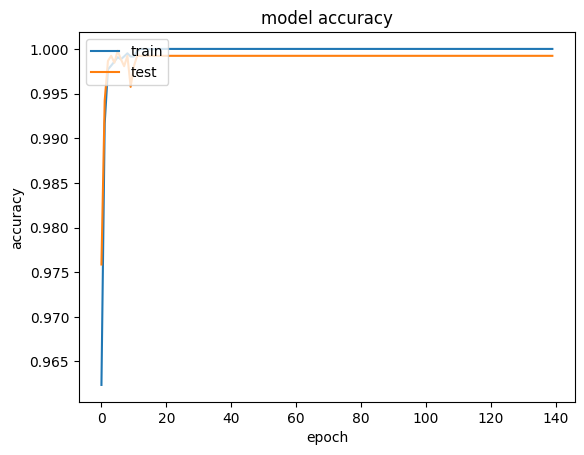

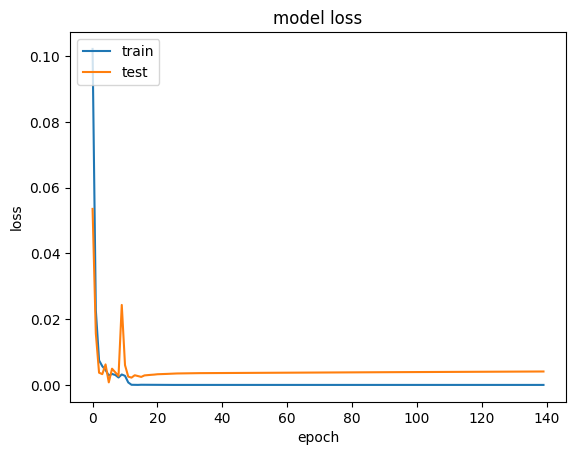

In [63]:
# summarize history for accuracy
print(history.history.keys())

plt.plot(history.history['Binary_Accuracy'])
plt.plot(history.history['val_Binary_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
pred = model.predict(X_test)
pred1=pred
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

9765/9765 [==============================] - 8s 778us/step


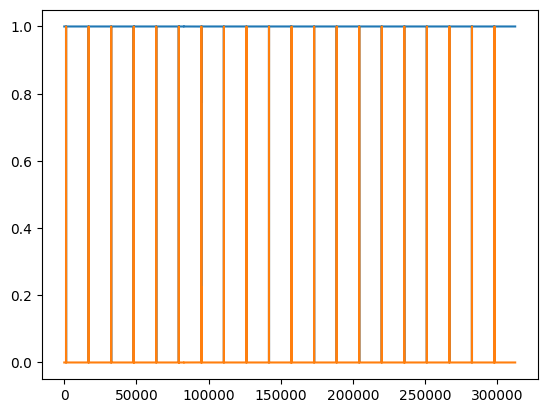

In [65]:
plt.plot(pred1)

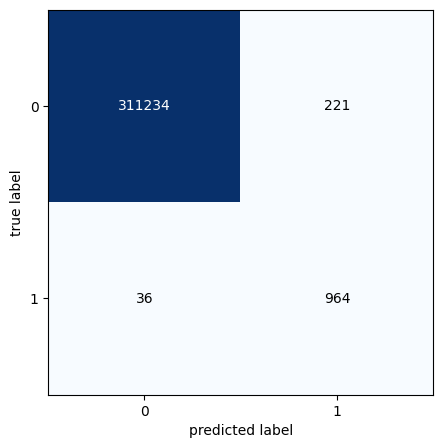

In [66]:
thr=9.99999821
#CM = confusion_matrix(y_true, pred>thr)
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()


In [67]:
tn, fp, fn, tp = CM.ravel()
def accuracy(tn, fp, fn, tp):
    return (tp + tn) / (tp + tn + fp + fn)

In [68]:
def precision(tn, fp, fn, tp):
    return(tp/(tp+fp))

In [69]:
def recall(tn, fp, fn, tp):
    return(tp/(tp+fn))

In [70]:
"Accuracy: {0}".format(accuracy(tn, fp, fn, tp))

'Accuracy: 0.9991774815573442'

In [71]:
"Precision: {0}".format(precision(tn, fp, fn, tp))

'Precision: 0.8135021097046413'

In [72]:
"Recall: {0}".format(recall(tn, fp, fn, tp))

'Recall: 0.964'

In [73]:
labels=np.array([i[0] for i in y_test])

In [74]:
fp,tp,thresholds=roc_curve(labels,pred1[:,0])

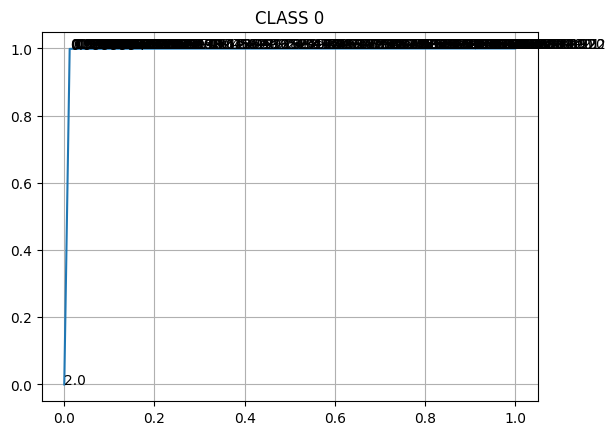

In [75]:
plt.plot(fp,tp)
plt.title("CLASS 0")
plt.grid()

skip=5
for i in range(0,len(thresholds),skip):
    plt.text(fp[i],tp[i],thresholds[i])

In [76]:
fp2,tp2,thresholds2=roc_curve(labels,pred1[:,1])

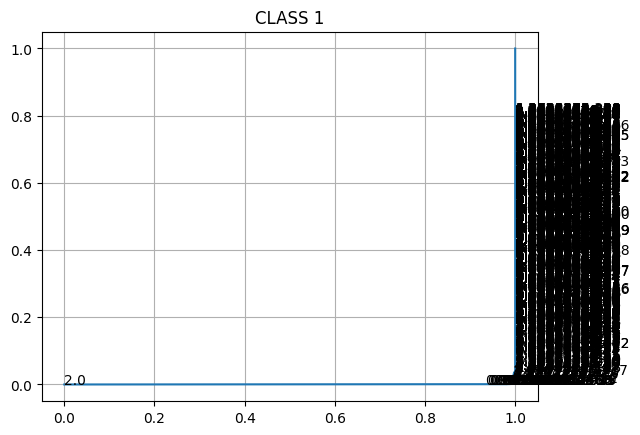

In [77]:
plt.plot(fp2,tp2)
plt.title("CLASS 1")
plt.grid()

skip=5
for i in range(0,len(thresholds2),skip):
    plt.text(fp2[i],tp2[i],thresholds2[i])

In [37]:
#For Further Testing with Hamming weights run bellow:

X = genfromtxt('C:/Users/NSF/Desktop/boyang work/final/XMEGA/DATASETS/self_capture/traces_train_1000_20_20.csv', delimiter=',')
X[np.isinf(X)] = 0
for i in range(np.shape(X)[0]):
    X[i]=preprocessing.normalize([X[i]])


In [38]:
pred = model.predict(X)
pred1=pred
pred = np.argmax(pred,axis = 1) 

9765/9765 [==============================] - 8s 759us/step


In [39]:
savetxt('predictions/megamgea.csv', pred, delimiter=',')

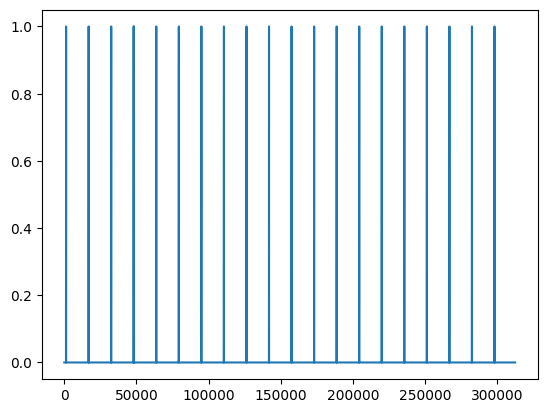

In [78]:
plt.plot(pred)